In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
print(path_to_zip)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(f'PATH is: {PATH}')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68616192/68606236 [==============================] - 1s 0us/step
/root/.keras/datasets/cats_and_dogs.zip
PATH is: /root/.keras/datasets/cats_and_dogs_filtered
Found 2000 files belonging to 2 classes.


In [ ]:
! ls /root/.keras/datasets/cats_and_dogs_filtered

train  validation  vectorize.py


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [ ]:
train_dataset.class_names

['cats', 'dogs']

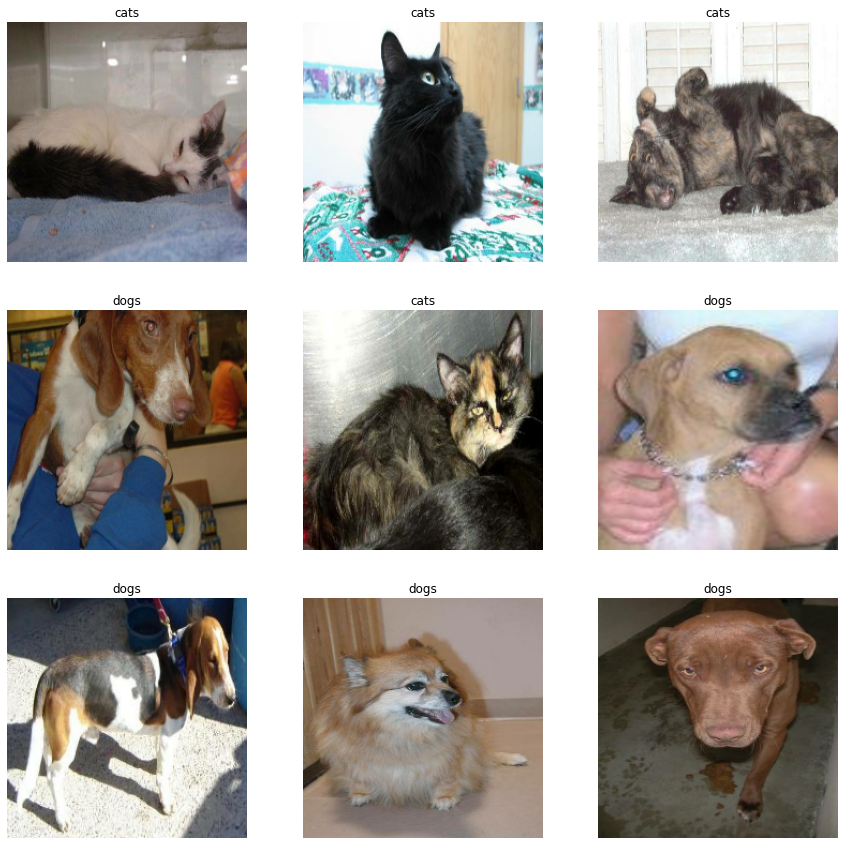

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)


In [ ]:
val_batches


<tf.Tensor: shape=(), dtype=int64, numpy=32>

In [ ]:
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
preprocess_input

<function keras.applications.vgg16.preprocess_input>

**ResNet50 Model**

In [ ]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  print(layer.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 230, 230, 3), dtype=tf.float32, name=None), name='conv1_pad/Pad:0', description="created by layer 'conv1_pad'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 64), dtype=tf.float32, name=None), name='conv1_conv/BiasAdd:0', description="created by layer 'conv1_conv'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 64), dtype=tf.float32, name=None), name='conv1_bn/FusedBatchNormV3:0', description="created by layer 'conv1_bn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 64), dtype=tf.float32, name=None), name='conv1_relu/Relu:0', description="created by layer 'conv1_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 114, 114, 64), dtype=tf.float32, name=None), name='pool1_pad/Pad:0', description="created by layer 'pool1_pad'")
KerasTensor(type_spec=TensorSpec(

**Convert image**

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


**freezing layers**

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
def create_model():
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  return model

In [ ]:

base_learning_rate = 0.0001
initial_epochs = 5
model = create_model()

**Compiling the model**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
63/63 [==============================] - 16s 176ms/step - loss: 0.6083 - accuracy: 0.6485 - val_loss: 0.4196 - val_accuracy: 0.7847
Epoch 2/5
63/63 [==============================] - 10s 149ms/step - loss: 0.3718 - accuracy: 0.8305 - val_loss: 0.2787 - val_accuracy: 0.9010
Epoch 3/5
63/63 [==============================] - 10s 150ms/step - loss: 0.2596 - accuracy: 0.8955 - val_loss: 0.2038 - val_accuracy: 0.9394
Epoch 4/5
63/63 [==============================] - 10s 155ms/step - loss: 0.2010 - accuracy: 0.9350 - val_loss: 0.1639 - val_accuracy: 0.9579
Epoch 5/5
63/63 [==============================] - 10s 151ms/step - loss: 0.1687 - accuracy: 0.9470 - val_loss: 0.1372 - val_accuracy: 0.9678


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

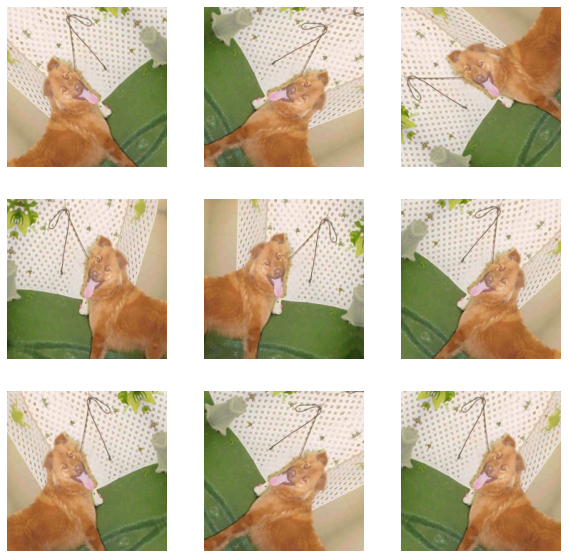

In [ ]:
for images, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
def create_new_model():
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  
  return model

In [ ]:
base_learning_rate = 0.0001
new_model = create_new_model()

In [ ]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history1 = new_model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset)

Epoch 1/5
63/63 [==============================] - 14s 166ms/step - loss: 0.1347 - accuracy: 0.9595 - val_loss: 0.1049 - val_accuracy: 0.9814
Epoch 2/5
63/63 [==============================] - 10s 152ms/step - loss: 0.1044 - accuracy: 0.9705 - val_loss: 0.0873 - val_accuracy: 0.9790
Epoch 3/5
63/63 [==============================] - 10s 154ms/step - loss: 0.0906 - accuracy: 0.9740 - val_loss: 0.0754 - val_accuracy: 0.9827
Epoch 4/5
63/63 [==============================] - 10s 152ms/step - loss: 0.0793 - accuracy: 0.9790 - val_loss: 0.0678 - val_accuracy: 0.9827
Epoch 5/5
63/63 [==============================] - 10s 152ms/step - loss: 0.0747 - accuracy: 0.9750 - val_loss: 0.0610 - val_accuracy: 0.9827


**Fine Tuning**

In [ ]:
base_model.trainable = True


In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 16

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
new_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:

new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                           

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_FineTune = new_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history1.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
63/63 [==============================] - 36s 387ms/step - loss: 0.0395 - accuracy: 0.9845 - val_loss: 0.1021 - val_accuracy: 0.9653
Epoch 6/10
63/63 [==============================] - 23s 367ms/step - loss: 0.0062 - accuracy: 0.9975 - val_loss: 0.0339 - val_accuracy: 0.9889
Epoch 7/10
63/63 [==============================] - 23s 363ms/step - loss: 2.4769e-04 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.9864
Epoch 8/10
63/63 [==============================] - 23s 359ms/step - loss: 2.0270e-04 - accuracy: 1.0000 - val_loss: 0.0363 - val_accuracy: 0.9901
Epoch 9/10
63/63 [==============================] - 23s 357ms/step - loss: 5.0110e-06 - accuracy: 1.0000 - val_loss: 0.0427 - val_accuracy: 0.9876
Epoch 10/10
63/63 [==============================] - 23s 361ms/step - loss: 2.2271e-07 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9889


Predictions:
 [1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0]
Labels:
 [1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0]


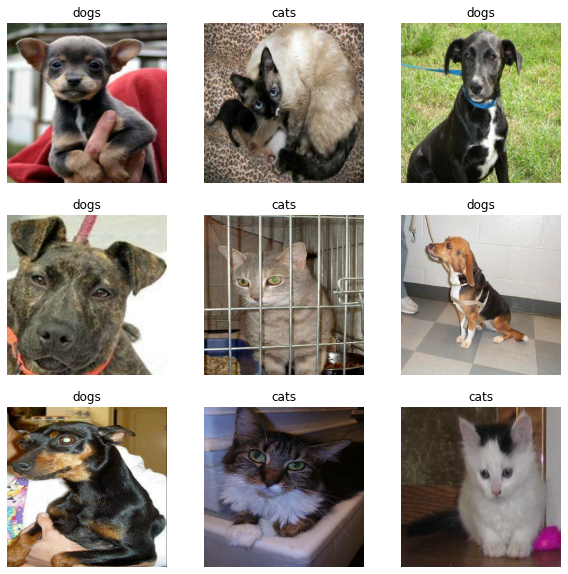

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = new_model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")